<a href="https://colab.research.google.com/github/SebastianSanchez5/DataAnalysis/blob/main/Sebastian_Sanchez_Copy_of_Exercise_Continuos_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capacity Planning for Texas's Power Grid with Time Series Analysis

**The Business Problem:** The Electric Reliability Council of Texas (ERCOT) manages the power grid for most of Texas. A critical task is **capacity planning**: ensuring there is enough electricity to meet demand, especially during peaks, to avoid blackouts. Underestimating demand leads to power outages, while overestimating leads to wasted resources and higher costs.

**Our Goal:** In this notebook, we'll act as consultants for ERCOT. We'll use time series analysis to decompose historical electricity demand data to understand its underlying patterns. This is the first step in building a predictive model for better capacity planning.

ERCOT provides archival data on their grid, which we'll be using for our analysis. ERCOT releases the [electricity usage of their grid](http://www.ercot.com/gridinfo/load) and they [provide archival copies of their data](http://www.ercot.com/gridinfo/load/load_hist).
(ERCOT also publishes their own load forecasts, this is a good baseline for any model.)

In [1]:
#@title Setup

!pip install -U -q statsmodels PyMySQL sqlalchemy

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

from sqlalchemy import create_engine
from sqlalchemy import text

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 227.4 kB/s eta 0:00:00


In [2]:
#@title Plotting Setup

%config InlineBackend.figure_format = 'retina'

# Change the graph defaults
plt.rcParams['figure.figsize'] = (8, 3)  # Default figure size of 8x3 inches
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = 'lightgray'
plt.rcParams['font.size'] = 10  # Default font size of 12 points
plt.rcParams['lines.linewidth'] = 1  # Default line width of 1 points
plt.rcParams['lines.markersize'] = 2  # Default marker size of 2 points
plt.rcParams['legend.fontsize'] = 10  # Default legend font size of 10 points

# Load and plot the data


In [3]:
conn_string = 'mysql+pymysql://{user}:{password}@{host}/{db}?charset=utf8mb4'.format(
    host = 'db.ipeirotis.org',
    user = 'student',
    password = 'dwdstudent2025',
    db = 'ercot',
    encoding = 'utf8mb4')

engine = create_engine(conn_string)

# This query loads the dataset from the DB into the dataframe
with engine.connect() as con:
  sql = "SELECT * FROM ercot.electricity"
  df = pd.read_sql(text(sql), con=con)
  df = df.set_index('DATE_TIME')

In [4]:
df

,COAST,EAST,FWEST,NORTH,NCENT,SOUTH,SCENT,WEST,ERCOT
DATE_TIME,,,,,,,,,
2002-01-01 01:00:00,8331.469266,1111.096549,1094.045496,995.298392,10336.304899,2165.007571,4793.193560,843.747177,29670.162911
2002-01-01 02:00:00,8107.805431,1091.481584,1083.517981,981.195477,10178.052738,2092.374118,4766.918187,835.488188,29136.833703
2002-01-01 03:00:00,7890.721717,1080.257616,1085.038740,971.305257,10100.887710,2042.080714,4702.918892,830.694878,28703.905525
2002-01-01 04:00:00,7799.817527,1079.726403,1093.381853,971.262963,10081.565109,2011.935791,4669.064391,835.068413,28541.822450
2002-01-01 05:00:00,7815.968171,1087.934961,1106.651296,982.535591,10192.218670,2002.487678,4695.011904,848.598209,28731.406478
...,...,...,...,...,...,...,...,...,...
2023-05-31 20:00:00,16830.963445,2173.074464,5757.713701,1430.314138,18926.254677,5160.743439,10820.919849,1471.589427,62571.573139
2023-05-31 21:00:00,16249.277372,2061.613777,5712.504436,1357.031324,18042.293868,4963.232330,10363.331700,1412.062420,60161.347225
2023-05-31 22:00:00,15690.099605,1953.621682,5696.530667,1305.911891,17295.147115,4810.546445,9939.491289,1384.384586,58075.733278


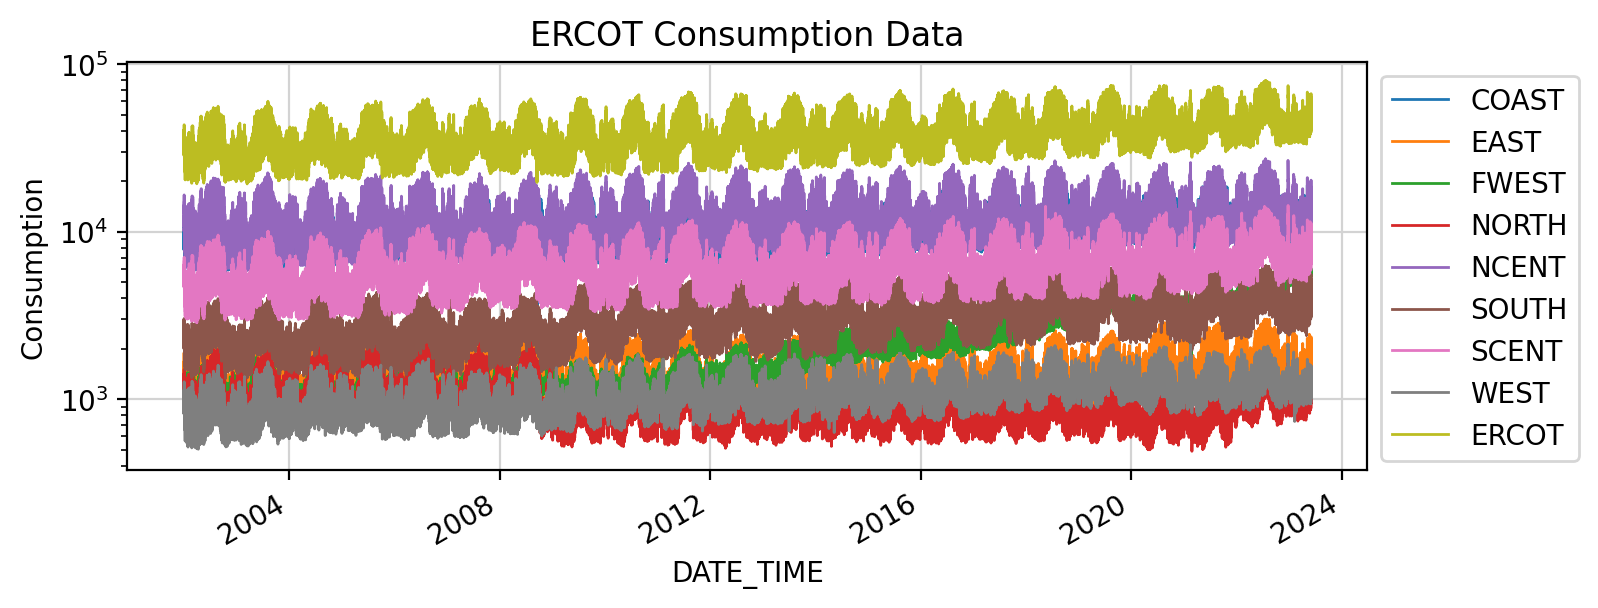

In [5]:
df.plot(
    logy=True,
    title='ERCOT Consumption Data',
    ylabel="Consumption"
)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left') # move the legend out of the chart

<Axes: title={'center': 'ERCOT Consumption Data'}, xlabel='DATE_TIME', ylabel='Consumption'>

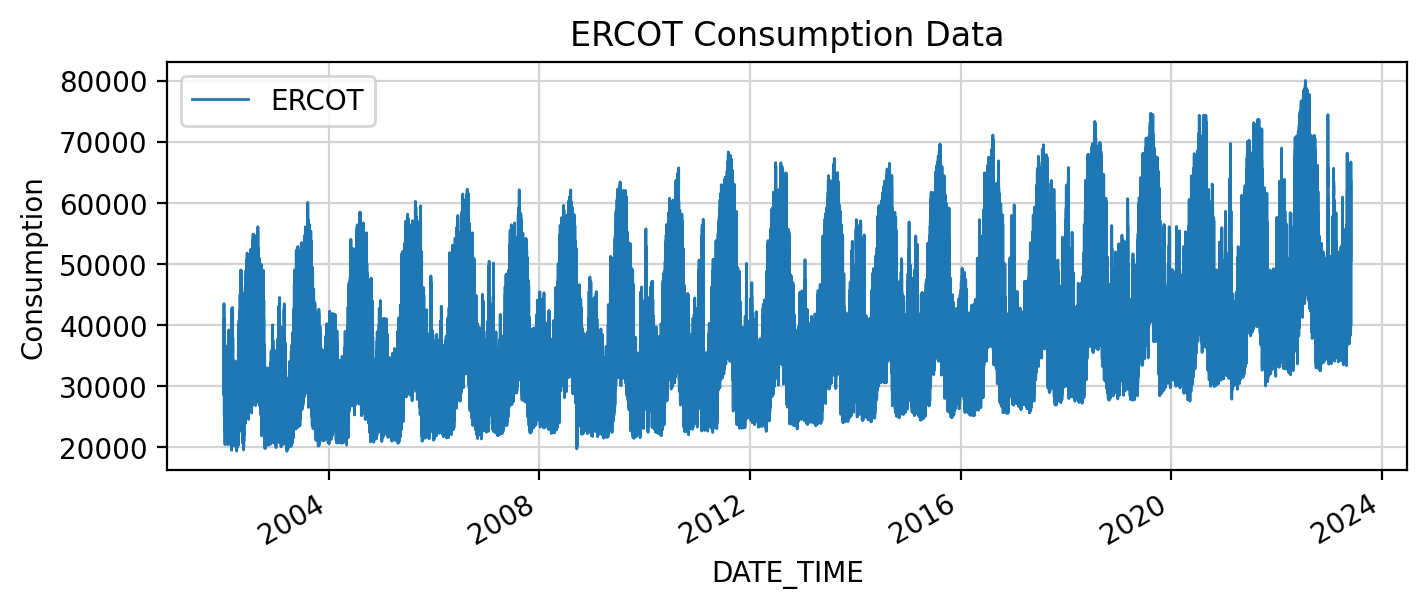

In [6]:
df.plot(
    y = 'ERCOT',
    title='ERCOT Consumption Data',
    ylabel="Consumption"
)

### Our Mission: Answering Key Business Questions

As we analyze this data, our goal is to answer the following questions for ERCOT's management:

1.  **Demand Growth:** How is electricity demand evolving over time? Can we project the overall trend for the next 5 years for long-term capacity planning?
2.  **Peak Demand:** We need to avoid blackouts. How can we project the *maximum* capacity needed? Can we create a confidence interval to show the range of maximum capacity required?
3.  **Regional Analysis:** How do these patterns differ by region? This is crucial for regional capacity planning (e.g., for the COAST, WEST, etc.).

## Decomposing the Time Series

To analyze this data effectively, we need to break it down into its core components. A time series is typically composed of:

1.  **Trend (T):** The long-term direction of the data (e.g., is demand generally increasing?).
2.  **Seasonality (S):** Predictable, repeating patterns or cycles (e.g., daily and yearly fluctuations).
3.  **Residual (R):** The random, unpredictable noise left over after removing the trend and seasonality.

We'll use a technique called **seasonality decomposition** to separate these components.

In [7]:
# We call our main time series Y
Y = df['ERCOT']

### Extracting Daily Seasonal Component

In [8]:
Y = df.ERCOT

decompose = seasonal_decompose(Y,
                                model='multiplicative',
                                period=24, #daily seasonality, 24 hours period
                                extrapolate_trend=24)

T_d, S_d, R_d = decompose.trend, decompose.seasonal, decompose.resid

<Axes: xlabel='DATE_TIME'>

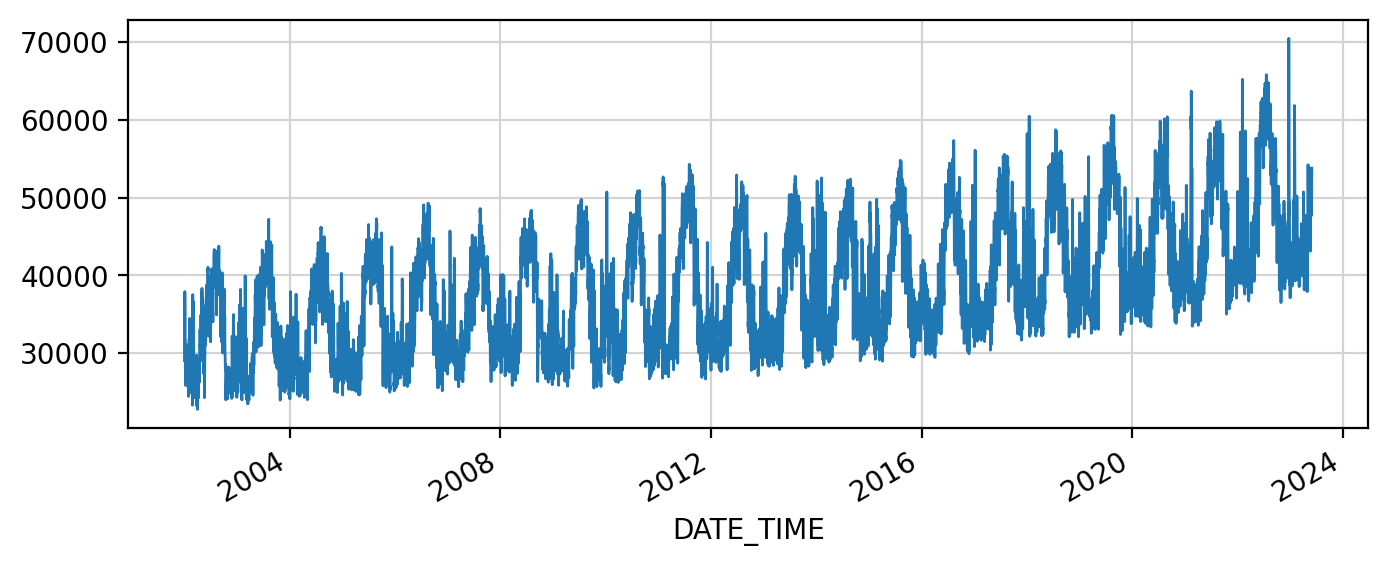

In [9]:
# plot the trend, after we remove daily seasonality
T_d.plot()

### Analysis of the Daily Seasonality

The plot above shows the typical daily demand cycle. As expected, demand is lowest in the early morning hours and peaks in the late afternoon and evening as people come home from work and use more electricity. This daily pattern is a critical input for short-term operational planning.

<Axes: xlabel='DATE_TIME'>

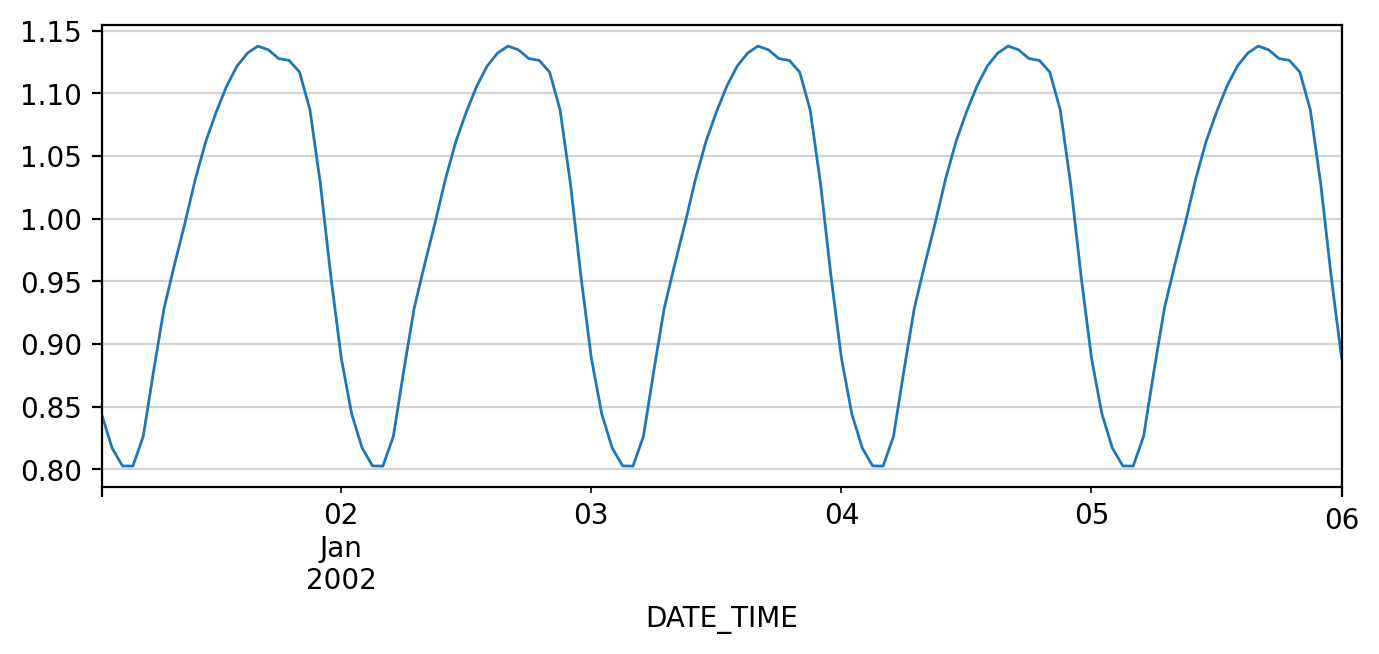

In [10]:
(
    S_d # the daily seasonal trend
    .head(24 * 5) # plot the first five days
    .plot()
)

We also plot the residuals to see the quality of the removal of the seasonal component. Honestly, not a great outcome: our techniques are pretty naive, and do not account for the fluctuating magnitude of the changes (aka "_clustered volatility_"). Dealing with clustered volatility requires more advanced models than the ones we are currently using.

<Axes: xlabel='DATE_TIME'>

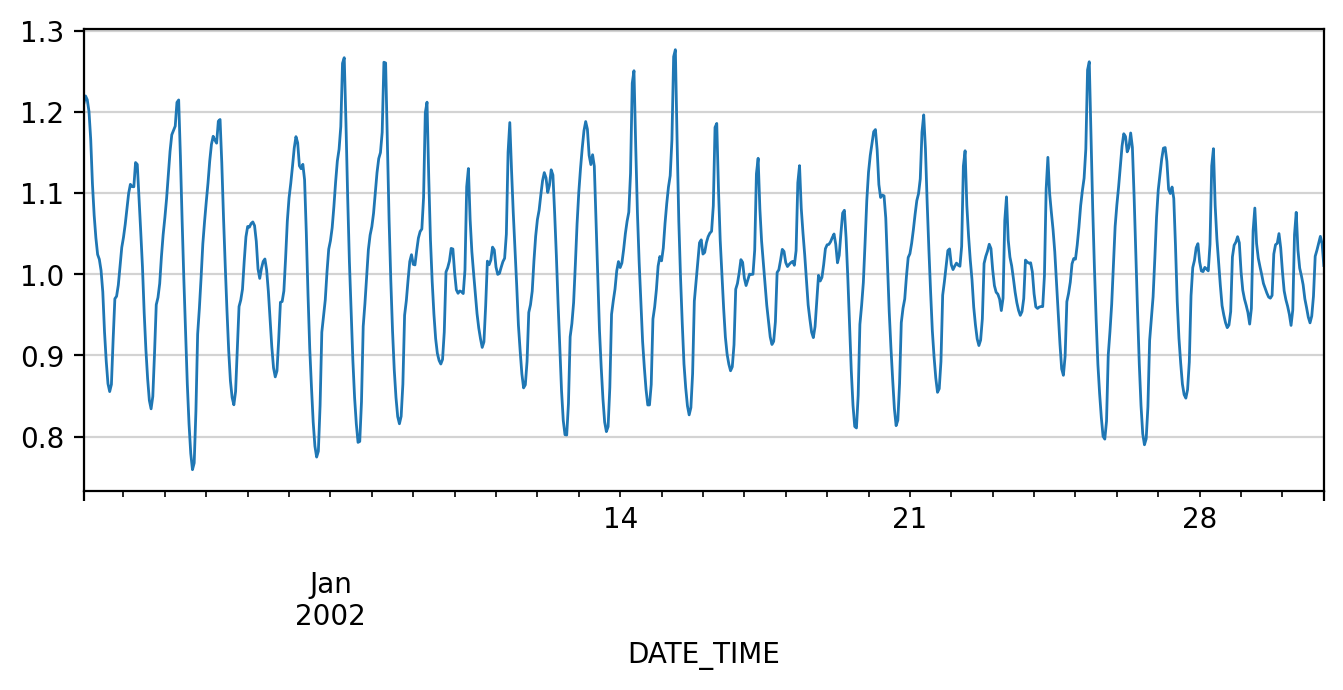

In [11]:
(
    R_d # the residual factors after removing the daily seasonal
    .head(24 * 30) # plot the first 30 days
    .plot()
)

### Analyzing further the $T_d$ Component: Identifying Weekly Patterns

We have extracted three time series (trend, seasonal, residual) from the main time series, after extracting the daily component. Now we will extract the weekly component, which has a duration of `period = 24 * 7` hours.

In [12]:
decompose = seasonal_decompose(T_d,
                                model='multiplicative',
                                period=24 * 7, # Period of one week, (7 daye * 24 hours)
                                extrapolate_trend=24 * 7)

T_w, S_w, R_w = decompose.trend, decompose.seasonal, decompose.resid

<Axes: xlabel='DATE_TIME'>

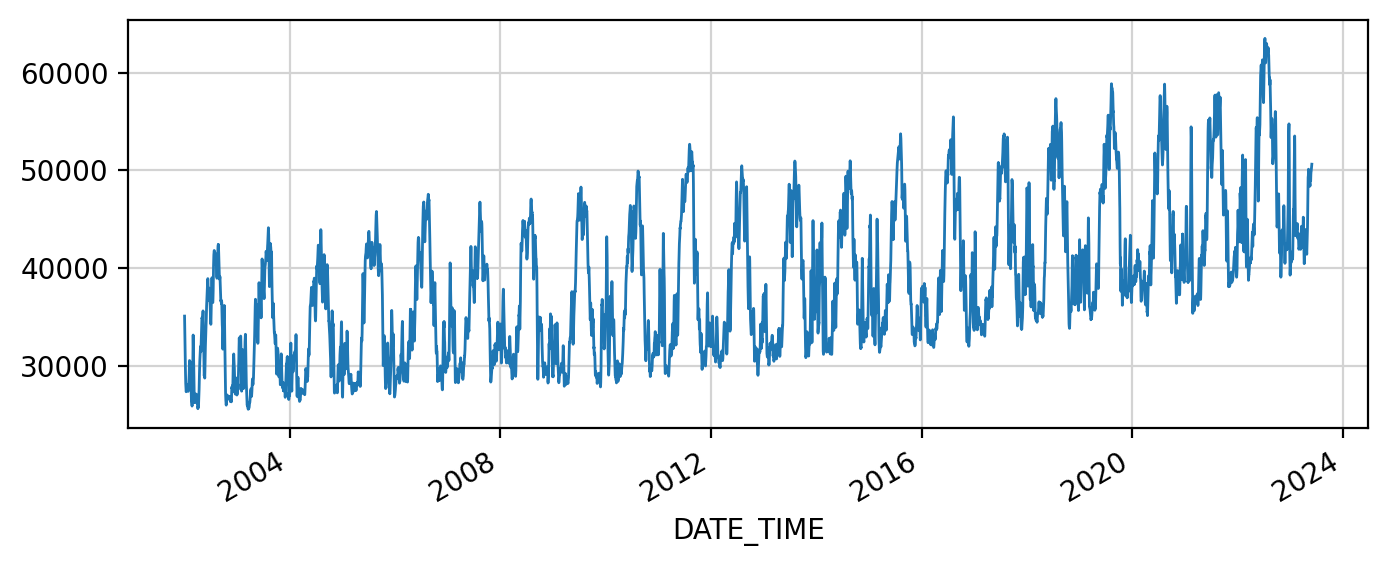

In [13]:
# This is the remaining trend component after removing daily and weekly fluctuations
T_w.plot()

### Analysis of the Weekly Seasonality

This plot reveals the weekly demand pattern. We can see a clear drop in demand during the weekends (Saturdays and Sundays) compared to the weekdays. This weekly pattern is essential for medium-term planning, such as scheduling maintenance.

<Axes: xlabel='DATE_TIME'>

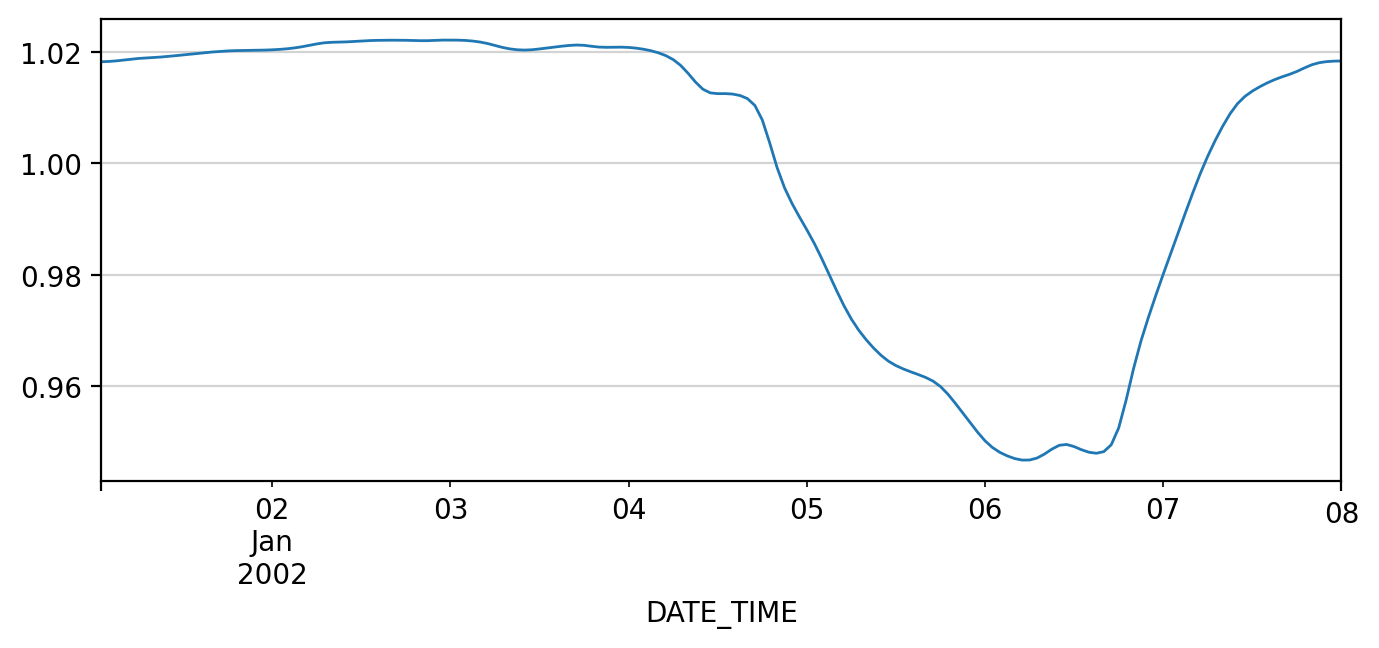

In [14]:
# This shows the weekly seasonality
S_w.head(24*7).plot()

<Axes: xlabel='DATE_TIME'>

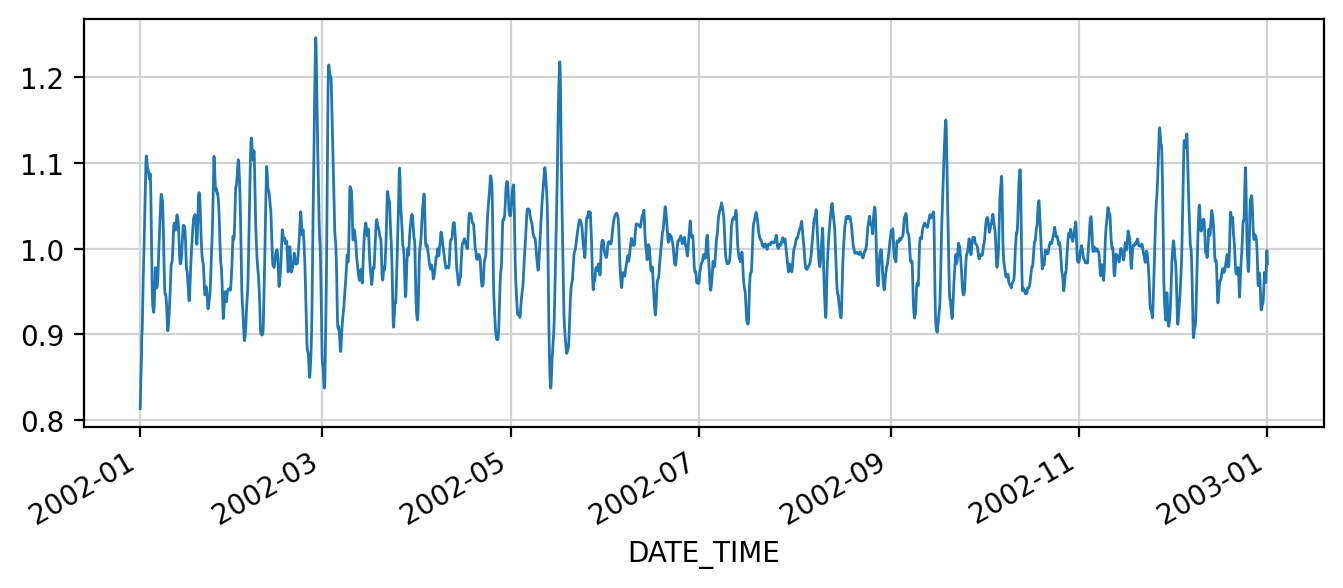

In [15]:
# This shows the residual, after removing the daily and weekly
R_w.head(24*365).plot()

### Analyzing further the $T_w$ Component: Identifying yearly Patterns

In [18]:
decompose = seasonal_decompose(T_w,
                                model='multiplicative',
                                period=24 * 365, #Yearly seasonality (365 days * 24 hours)
                                extrapolate_trend=24 * 365)

T_y, S_y, R_y = decompose.trend, decompose.seasonal, decompose.resid

<Axes: xlabel='DATE_TIME'>

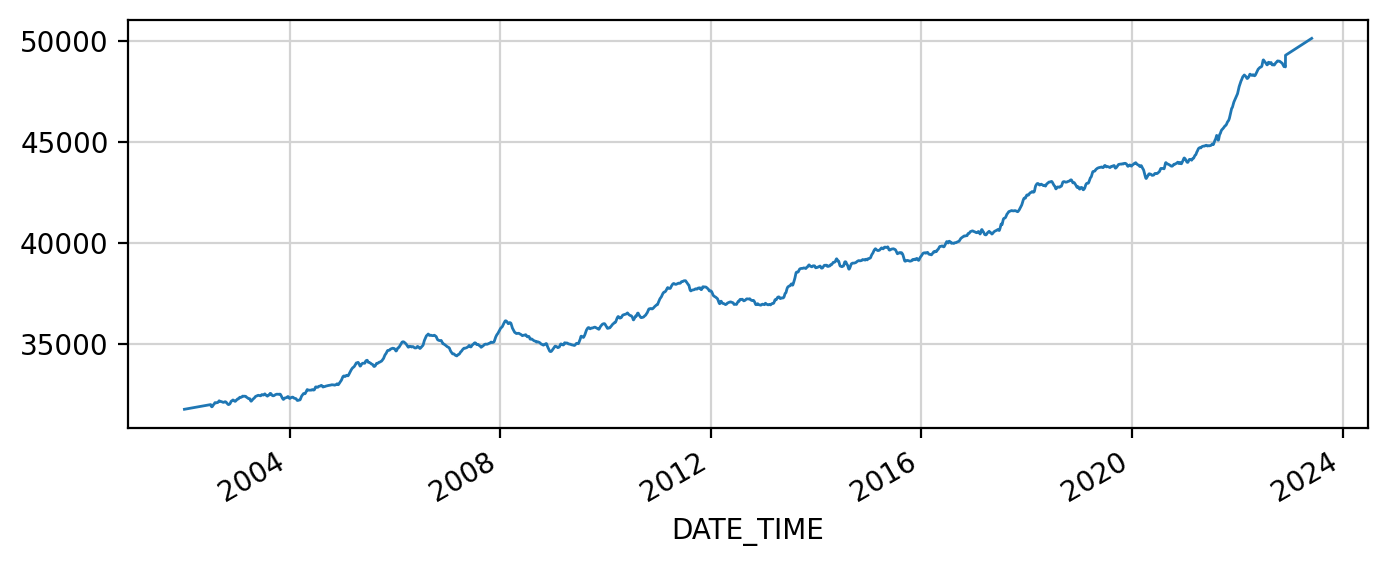

In [17]:
# This shows the overall trend, after removing daily, weekly, and yearly seasonality
T_y.plot()

In [ ]:
# This shows the yearly seasonality
S_y.head(24*365).plot()

## Summary

In [ ]:
# This shows the overall trend, after removing daily, weekly, and yearly seasonality
T_y.plot()

In [ ]:
# This shows the yearly seasonality. We show the
# first 365 days * 24 hours as the pattern repeats in subsequent periods
S_y.head(24*365).plot()

In [ ]:
# This shows the weekly seasonality. We show the first
# 7 days multiplied with 24 hours as the pattern repeats in subsequent periods
S_w.head(24*7).plot()

In [ ]:
# This shows the daily seasonality. We show the first
# 24 hours, as the pattern repeats in subsequent periods
S_d.head(24).plot()

In [ ]:
# This is the time series with the overall trend, plus seasonality
(T_y * S_y * S_w * S_d).plot()

In [ ]:
# This is the residual, that is not captured by the trend or seasonality
# When we are modeling, we really talk about forecasting the trend and
# potentially modeling this time series, which has been de-trended
# and de-seasonalized.
( R_y * R_w * R_d ).plot(figsize=(16,4), linewidth=0.5)

## Analyzing the Residuals to Quantify Risk

Now that we've isolated the Trend (T) and Seasonality (S), the final component to analyze is the **Residual (R)**. The residual represents the random, unpredictable "noise" in the data.

From a business perspective, the residual is crucial for **risk management**. While we can't predict the exact noise, we can analyze its distribution to understand the potential range of random fluctuations. This helps us answer: "How much of a safety buffer do we need for unexpected demand?"

Let's plot the residuals from our yearly decomposition.

In [ ]:
# Here is the histogram of the residuals.
# Since these are multiplicative factors, it is a good idea
# to also take the log and plot them again.
( R_y * R_w * R_d ).hist(bins=1000)

In [ ]:
np.log2( R_y * R_w * R_d ).hist(bins=1000)

### Using Quantiles to Set a Safety Buffer

The histogram shows that most of the fluctuations are in the +/-25% range, and moatly centered around zero. However, there are "tails" representing larger, less frequent spikes. We can use **quantiles** to precisely measure these tails.

This is how we can build a data-driven confidence interval for our planning.

In [ ]:
# Examine the quantiles of the residual distribution
# These are the values with which we need to multiply our
# trend and seasonality projections to estimate maximum capacity
#
# 99% = For 87.6 hours in a year, consumption is above this level
# 99.9% = For 8.76 hours in a year, consumption is above this level
# 99.99% = For 52 mins in a year, consumption is above this level
# 99.999% = For 5.2 mins in a year, consumption is above this level

q=[
    0.00001, 0.0001,0.001,0.01,0.1,0.25,
    0.5,
    0.75,0.9,0.99,0.999,0.9999,0.99999
]
(R_y * R_w * R_d).quantile(q)

In [ ]:
# Plots the histogram of the log of the time series after removing the trend
# The division Y / T_y removes the long term trend from the series and returns
# back the multiplicative factors S_y * S_w * S_d * R_y * R_w * R_d
np.log(Y / T_y).hist(bins=1000, alpha=0.75)

# Now let's remove the seasonal components as well and see the difference
# Plots the histogram of the log of the residuals after removing trend and seasonality
np.log(Y / (T_y * S_y * S_w * S_d)).hist(bins=1000, alpha=0.75)

## Conclusion & Next Steps

By decomposing the ERCOT time series, we've identified three key patterns:

* **A consistent daily cycle** driven by typical work and life schedules.
* **A clear weekly pattern** with lower demand on weekends and holidays.
* **A strong yearly seasonality** with peaks in summer and winter.
* **A clear upward trend** in overall electricity demand over the last two decades.

**Next Steps:** With this understanding, a data science team could now move on to forecasting future demand. They would use the trend as a baseline and then layer the seasonal patterns on top to create a predictive model. This model would be the foundation for making informed decisions on capacity planning and resource allocation.

#### Appendix (Optional): Periodogram

The periodogram is a graph that identifies the most important periodicities in the data. We typically apply that to a timeseries with zero trend. After that, we can extract the time periods to consider for periodicities. For most data, daily, weekly, and yearly are the three periods that we consider. In rare cases, a periodogram will reveal additional patterns.

In [ ]:
import numpy as np
from scipy.signal import periodogram
import matplotlib.pyplot as plt

# Create  a periodogram from the detrended ERCOT time series
freqs, psd = periodogram(Y / T_y)

# Create a dataframe with the results, and convert
# frequencies to time between events by taking the inverse
prd = pd.DataFrame({"freqs": freqs, "psd": psd})
prd['period_hours'] = 1/prd['freqs']

# Plot the results. Often people do a log on the y-axis, but
# for identifying the major components, I think that linear works
# better
prd.plot(
    x='period_hours',
    y = 'psd',
    ylabel = 'Power Spectral Density',
    logx=True,
    # logy=True
)

In [ ]:
# Let's look at what periods are the most powerful in the data
agg_prd = prd.copy()

agg_prd['period_hours'] = np.round(agg_prd['period_hours'])

agg_prd = agg_prd.pivot_table(
    index = 'period_hours',
    values = 'psd',
    aggfunc = 'sum'
).reset_index()

agg_prd.sort_values('psd', ascending=False).head(20)